In [1]:
from pathlib import Path
import re

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
pdata = Path(r"D:\OneDrive - UGent\research-proposals\VSC-2023\data")

# Training

In [6]:
def get_data(pfname: Path):
    data = json.loads(pfname.read_text(encoding="utf-8"))
    parent_stem = pfname.parent.stem

    n_nodes, n_gpus = map(int, re.search(r"(\d+)n-(\d+)g", parent_stem).groups())
    n_gpus_total = n_nodes * n_gpus
    return {
        "name": parent_stem,
        "type": pfname.parent.parent.stem,
        "n_nodes": n_nodes,
        "n_gpus": n_gpus,
        "n_gpus_total": n_gpus_total,
        "runtime": data["train_runtime"],
        "sps": data["train_samples_per_second"]
    }

df = pd.DataFrame([get_data(pfin) for pfin in pdata.rglob("train_results.json")])

item_1n1g = lambda t, c: df.loc[(df["name"] == "1n-1g") & (df["type"] == t)][c].item()
df["sps_efficiency"] = df.apply(lambda row: row["sps"] / item_1n1g(row["type"], "sps") / row["n_gpus_total"], axis=1)
df["sps_improvement"] = df.apply(lambda row: row["sps"] / item_1n1g(row["type"], "sps"), axis=1)
df["runtime_efficiency"] = df.apply(lambda row: item_1n1g(row["type"], "runtime") / row["runtime"] / row["n_gpus_total"], axis=1)
df["runtime_improvement"] = df.apply(lambda row: item_1n1g(row["type"], "runtime") / row["runtime"], axis=1)
df = df.sort_values(by=["type", "n_nodes", "n_gpus"])
df.to_excel("analysis.xlsx", index=False)

df

,name,type,n_nodes,n_gpus,n_gpus_total,runtime,sps,sps_efficiency,sps_improvement,runtime_efficiency,runtime_improvement
1,1n-1g,default,1,1,1,320.9536,6.381,1.000000,1.000000,1.000000,1.000000
2,1n-2g,default,1,2,2,162.3545,12.614,0.988403,1.976806,0.988435,1.976869
3,1n-3g,default,1,3,3,113.5842,18.031,0.941911,2.825733,0.941896,2.825689
4,1n-4g,default,1,4,4,84.4024,24.265,0.950674,3.802696,0.950665,3.802660
5,2n-4g,default,2,4,8,65.9029,31.076,0.608760,4.870083,0.608762,4.870098
6,3n-4g,default,3,4,12,46.0847,44.440,0.580369,6.964426,0.580369,6.964429
7,4n-4g,default,4,4,16,35.5767,57.566,0.563842,9.021470,0.563841,9.021455
8,5n-4g,default,5,4,20,29.6339,69.110,0.541530,10.830591,0.541531,10.830623
9,6n-4g,default,6,4,24,22.4544,91.207,0.595564,14.293528,0.595566,14.293573
10,7n-4g,default,7,4,28,22.0065,93.063,0.520871,14.584391,0.520875,14.584491


Text(0.5, 1.0, 'Runtime improvements compared to single node, single GPU')

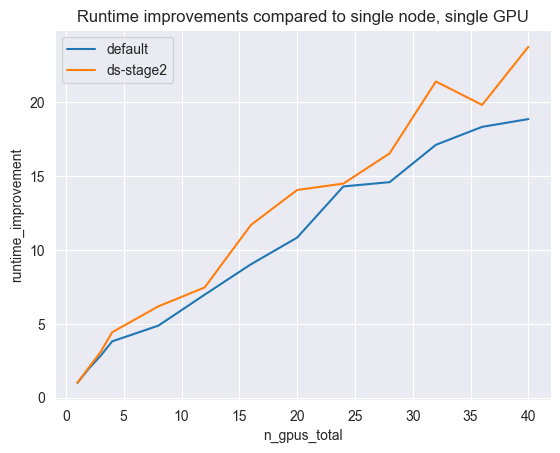

In [4]:
fig, ax = plt.subplots()

for ds_type, group_df in df.groupby("type"):
    sns.lineplot(group_df, x="n_gpus_total", y="runtime_improvement", label=ds_type)
plt.legend()
plt.title("Runtime improvements compared to single node, single GPU")

Text(0.5, 1.0, 'Runtime efficiency compared to single node, single GPU')

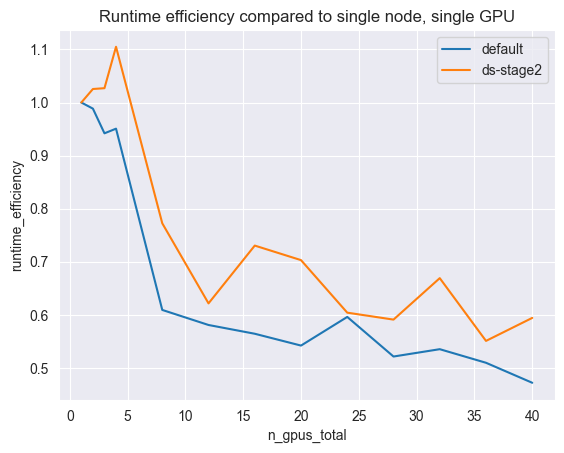

In [5]:
for ds_type, group_df in df.groupby("type"):
    sns.lineplot(group_df, x="n_gpus_total", y="runtime_efficiency", label=ds_type)
plt.legend()
plt.title("Runtime efficiency compared to single node, single GPU")